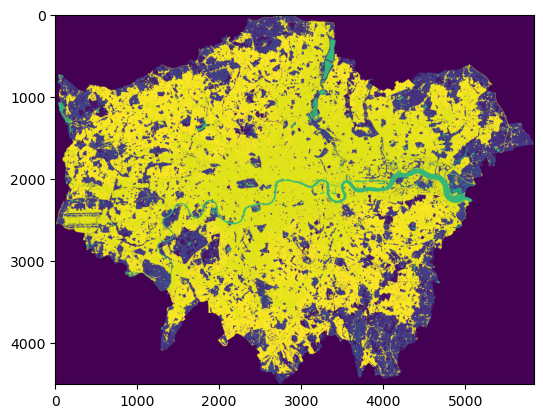

<Axes: >

In [4]:
import rasterio
from rasterio.plot import show

dataset = rasterio.open('FME_36643839_1740866308205_5696/data/7727ce7d-531e-4d77-b756-5cc59ff016bd/ukregion-london.tif')
show(dataset.read(1))

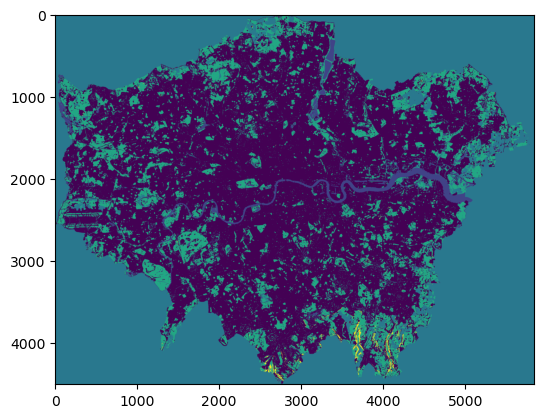

In [3]:

from osgeo import gdal
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin

def load_mask_and_confidence(tiff_path):
    # Open the TIFF file
    dataset = gdal.Open(tiff_path)
    
    # Read the mask (band 1) and confidence (band 2)
    mask_band = dataset.GetRasterBand(1)
    confidence_band = dataset.GetRasterBand(2)
    
    # Read as NumPy arrays
    mask_data = mask_band.ReadAsArray()  # Read band 1 (mask data)
    confidence_data = confidence_band.ReadAsArray()  # Read band 2 (confidence data)
    
    return mask_data, confidence_data

# Example usage:
mask_data, confidence_data = load_mask_and_confidence('FME_36643839_1740866308205_5696/data/7727ce7d-531e-4d77-b756-5cc59ff016bd/ukregion-london.tif')

def refine_land_use_mask(mask):
    refined_mask = np.copy(mask)
    
    # Urban: Classes 20 (Urban), 21 (Suburban)
    refined_mask[np.isin(mask, [20, 21])] = 1  # Urban

    # Water: Saltwater (7, 13), Freshwater (8, 14), and related classes
    refined_mask[np.isin(mask, [7, 8, 13, 14, 15, 16, 17, 18, 19])] = 2  # Water

    # Other: All other classes
    refined_mask[~np.isin(mask, [1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20, 21])] = 3  # Other

    return refined_mask

def save_refined_mask_as_tiff(refined_mask, output_path, input_tiff_path):
    # Open the original TIFF to get its metadata (such as geotransform and CRS)
    with rasterio.open(input_tiff_path) as src:
        # Get the transform and metadata from the original file
        transform = src.transform
        crs = src.crs
        dtype = src.dtypes[0]  # Assuming the data type of the mask is the same as the input
        
        # Create the new output file with the same metadata as the original
        with rasterio.open(output_path, 'w', driver='GTiff', 
                           count=1,  # Single band for the refined mask
                           dtype=dtype, 
                           crs=crs, 
                           transform=transform, 
                           width=refined_mask.shape[1], 
                           height=refined_mask.shape[0]) as dst:
            dst.write(refined_mask, 1)  # Write the refined mask to band 1

# Example usage:
# Assuming `mask_data` is your original land use mask
refined_mask = refine_land_use_mask(mask_data)
show(refined_mask)
output_path = 'refined_mask_new.tif'
input_tiff_path = 'FME_36643839_1740866308205_5696/data/7727ce7d-531e-4d77-b756-5cc59ff016bd/ukregion-london.tif'
save_refined_mask_as_tiff(refined_mask, output_path, input_tiff_path)

Selected LiDAR file: Lidar_Tiffs\DSM_TQ1575_P_12757_20230109_20230315.tif
Top-left corner coordinates: (144, 109)
LiDAR patch shape: (224, 224)
Mask patch shape: (224, 224)


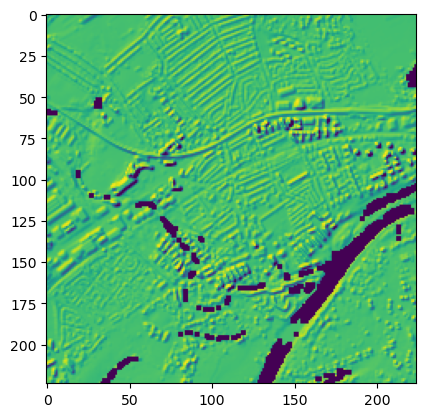

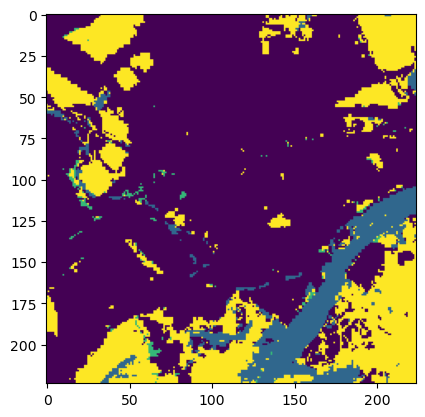

In [5]:
import random
import numpy as np
import rasterio
from osgeo import gdal
from rasterio.windows import Window
from rasterio.plot import show
import os

def downsample_raster(input_raster_path, output_raster_path, target_resolution=(10, 10)):
    # Open the raster
    raster = gdal.Open(input_raster_path)
    geo_transform = raster.GetGeoTransform()
    projection = raster.GetProjection()

    # Calculate the output dimensions
    cols = int(raster.RasterXSize * geo_transform[1] / target_resolution[0])
    rows = int(raster.RasterYSize * abs(geo_transform[5]) / target_resolution[1])

    # Perform the resampling using gdal.Warp
    resampled_raster = gdal.Warp(output_raster_path, raster, xRes=target_resolution[0], yRes=target_resolution[1], resampleAlg=gdal.GRA_Average)

    # Return the path of the downsampled raster
    return resampled_raster

def create_hillshade(lidar_file, hillshade_output_path):
    # Create a hillshade from the LiDAR file using GDAL's DEMProcessing
    gdal.DEMProcessing(
        hillshade_output_path,
        lidar_file,
        "hillshade",
        azimuth=315.0,
        altitude=45.0,
        scale=1.0,
        zFactor=1.0
    )
    return hillshade_output_path
    
def get_random_patch_from_lidar_and_mask(lidar_files, mask_ds, patch_size):
    # Step 1: Choose a random LiDAR file
    lidar_file = random.choice(lidar_files)
    
    # Downsample LiDAR file if it's not already downsampled
    downsampled_lidar_file = lidar_file.replace('.tif', '_downsampled.tif')
    if not os.path.exists(downsampled_lidar_file):
        downsample_raster(lidar_file, downsampled_lidar_file, target_resolution=(10, 10))  # Downsample to 10x10 resolution

    # Create hillshade for the downsampled LiDAR file
    hillshade_file = downsampled_lidar_file.replace('.tif', '_hillshade.tif')
    if not os.path.exists(hillshade_file):
        create_hillshade(downsampled_lidar_file, hillshade_file)

    # Open the downsampled hillshade dataset
    with rasterio.open(hillshade_file) as lidar_ds:
        lidar_width, lidar_height = lidar_ds.width, lidar_ds.height
        
        # Step 2: Ensure the patch is within the bounds of the LiDAR file
        max_x = lidar_width - patch_size
        max_y = lidar_height - patch_size
        
        # Step 3: Randomly choose the top-left corner for the LiDAR patch
        top_left_x = random.randint(0, max_x)
        top_left_y = random.randint(0, max_y)
        
        # Step 4: Convert LiDAR pixel coordinates to spatial coordinates using the affine transform
        lidar_transform = lidar_ds.transform
        lidar_x, lidar_y = lidar_transform * (top_left_x, top_left_y)
        
        # Step 5: Map the same spatial coordinates to the mask dataset
        # Convert LiDAR's spatial coordinates to mask pixel coordinates
        mask_transform = mask_ds.transform
        mask_x, mask_y = ~mask_transform * (lidar_x, lidar_y)
        
        # Step 6: Read the LiDAR patch (224x224)
        lidar_patch = lidar_ds.read(1, window=Window(top_left_x, top_left_y, patch_size, patch_size))
        
        # Step 7: Read the mask patch (224x224) from the mask dataset at the corresponding coordinates
        mask_patch = mask_ds.read(1, window=Window(int(mask_x), int(mask_y), patch_size, patch_size))
    
    return lidar_patch, mask_patch, top_left_x, top_left_y, lidar_file

# Example usage:
lidar_folder = "Lidar_Tiffs"
mask_path = "refined_mask_new.tif"

# Step 6: List all LiDAR files in the folder
lidar_files = [os.path.join(lidar_folder, f) for f in os.listdir(lidar_folder) if f.endswith('.tif')]

# Open the mask dataset
with rasterio.open(mask_path) as mask_ds:
    patch_size = 224  # 224x224 pixel patch size
    lidar_patch, mask_patch, top_left_x, top_left_y, lidar_file = get_random_patch_from_lidar_and_mask(lidar_files, mask_ds, patch_size)

    print(f"Selected LiDAR file: {lidar_file}")
    print(f"Top-left corner coordinates: ({top_left_x}, {top_left_y})")
    print(f"LiDAR patch shape: {lidar_patch.shape}")
    print(f"Mask patch shape: {mask_patch.shape}")
    show(lidar_patch)
    show(mask_patch)

In [6]:
import random
import numpy as np
import rasterio
from osgeo import gdal
from rasterio.windows import Window
from rasterio.plot import show
import os
import pandas as pd

# Function to downsample the raster to 10x10 resolution
def downsample_raster(input_raster_path, output_raster_path, target_resolution=(10, 10)):
    raster = gdal.Open(input_raster_path)
    geo_transform = raster.GetGeoTransform()
    projection = raster.GetProjection()
    cols = int(raster.RasterXSize * geo_transform[1] / target_resolution[0])
    rows = int(raster.RasterYSize * abs(geo_transform[5]) / target_resolution[1])
    
    # Perform the resampling using gdal.Warp
    resampled_raster = gdal.Warp(output_raster_path, raster, xRes=target_resolution[0], yRes=target_resolution[1], resampleAlg=gdal.GRA_Average)
    return resampled_raster

# Function to create hillshade from the LiDAR dataset
def create_hillshade(lidar_file, hillshade_output_path):
    gdal.DEMProcessing(
        hillshade_output_path,
        lidar_file,
        "hillshade",
        azimuth=315.0,
        altitude=45.0,
        scale=1.0,
        zFactor=1.0
    )
    return hillshade_output_path

# Function to get a random patch from both LiDAR and mask datasets
def get_random_patch_from_lidar_and_mask(lidar_files, mask_ds, patch_size):
    lidar_file = random.choice(lidar_files)
    
    # Downsample LiDAR file if it's not already downsampled
    downsampled_lidar_file = os.path.join("Downsampled_tiffs", os.path.basename(lidar_file).replace('.tif', '_downsampled.tif'))
    if not os.path.exists(downsampled_lidar_file):
        downsample_raster(lidar_file, downsampled_lidar_file, target_resolution=(10, 10))
    
    # Create hillshade from the downsampled LiDAR file
    hillshade_file = downsampled_lidar_file.replace('.tif', '_hillshade.tif')
    if not os.path.exists(hillshade_file):
        create_hillshade(downsampled_lidar_file, hillshade_file)

    # Open the hillshade dataset
    with rasterio.open(hillshade_file) as lidar_ds:
        lidar_width, lidar_height = lidar_ds.width, lidar_ds.height
        
        max_x = lidar_width - patch_size
        max_y = lidar_height - patch_size
        
        # Randomly select the top-left corner for the patch
        top_left_x = random.randint(0, max_x)
        top_left_y = random.randint(0, max_y)
        
        # Convert LiDAR pixel coordinates to spatial coordinates using the affine transform
        lidar_transform = lidar_ds.transform
        lidar_x, lidar_y = lidar_transform * (top_left_x, top_left_y)
        
        # Map the spatial coordinates to the mask dataset
        mask_transform = mask_ds.transform
        mask_x, mask_y = ~mask_transform * (lidar_x, lidar_y)
        
        # Read the LiDAR and mask patches
        lidar_patch = lidar_ds.read(1, window=Window(top_left_x, top_left_y, patch_size, patch_size))
        mask_patch = mask_ds.read(1, window=Window(int(mask_x), int(mask_y), patch_size, patch_size))
    
    return lidar_patch, mask_patch, top_left_x, top_left_y, lidar_file

# Function to sample patches and store them in a pandas DataFrame
def sample_patches_and_create_dataframe(lidar_files, mask_path, num_patches=2, patch_size=224):
    patches_data = []

    # Open the mask dataset
    with rasterio.open(mask_path) as mask_ds:
        for lidar_file in lidar_files:
            for _ in range(num_patches):  # Generate `num_patches` per LiDAR file
                lidar_patch, mask_patch, top_left_x, top_left_y, lidar_file = get_random_patch_from_lidar_and_mask([lidar_file], mask_ds, patch_size)
                
                # Collect relevant data
                patches_data.append({
                    'lidar_file': lidar_file,
                    'mask_file': mask_path,
                    'topleft': (top_left_y,top_left_x),
                    'width': patch_size
                })
    
    # Convert the collected data to a pandas DataFrame
    patches_df = pd.DataFrame(patches_data)
    return patches_df

# Example usage
lidar_folder = "Lidar_Tiffs"
mask_path = "refined_mask_new.tif"

# List all LiDAR files in the folder
lidar_files = [os.path.join(lidar_folder, f) for f in os.listdir(lidar_folder) if f.endswith('.tif')]

# Create the Downsampled_tiffs folder if it doesn't exist
os.makedirs("Downsampled_tiffs", exist_ok=True)

# Generate patches and store them in a DataFrame
patches_df = sample_patches_and_create_dataframe(lidar_files, mask_path, num_patches=2, patch_size=224)

# Save the DataFrame to a CSV or Pickle file
patches_df.to_csv('patches_data.csv', index=False)
# Or to save as pickle
# patches_df.to_pickle('patches_data.pkl')

# Show the first few rows of the DataFrame
print(patches_df.head())

                                          lidar_file             mask_file  \
0  Lidar_Tiffs\DSM_TQ1565_P_12756_20230116_202301...  refined_mask_new.tif   
1  Lidar_Tiffs\DSM_TQ1565_P_12756_20230116_202301...  refined_mask_new.tif   
2  Lidar_Tiffs\DSM_TQ1570_P_12756_20230116_202301...  refined_mask_new.tif   
3  Lidar_Tiffs\DSM_TQ1570_P_12756_20230116_202301...  refined_mask_new.tif   
4  Lidar_Tiffs\DSM_TQ1575_P_12757_20230109_202303...  refined_mask_new.tif   

      topleft  width  
0    (6, 247)    224  
1  (170, 247)    224  
2    (174, 7)    224  
3  (124, 126)    224  
4  (192, 224)    224  


In [ ]:
from test_dataloader import create_dataloader  # assuming 'create_dataloader' is in test_dataloader.py
from test_model import create_model  # assuming 'create_model' is in test_model.py
from test_train import train_model  # assuming 'train_model' is in test_train.py
import pandas as pd

if __name__ == "__main__":
    df = pd.read_csv('patches_data.csv')
    
    train_loader, val_loader, test_loader = create_dataloader(
        df, 
        splits=(0.8, 0.1, 0.1), 
        batch_size=32, 
        random_state=42, 
        n_workers=4, 
        pin_mem=True, 
    )

    model = create_model(out_classes=3, in_channels=1, enc_name="resnet18", enc_weights="imagenet")
    train_model(
        model, 
        train_loader, 
        val_loader, 
        test_loader, 
        results_base_dir='results', 
        epochs_total=20, 
        lr1=1e-4, 
        use_adam=True, 
        start_epoch=0
    )